In [95]:
import pandas as pd
import numpy as np
import sys
import os
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import scipy.stats as stats

#sys.path.append(os.path.abspath('../src'))

In [80]:

def TMensual(Tmort):
    """
    Interpola los valores de l(x) en pasos de 1/12 (mensual) y calcula q(x) y p(x).
    
    Parameters:
    Tmort (DataFrame): DataFrame que contiene las columnas 'x' y 'l(x)'.
    
    Returns:
    DataFrame: DataFrame con valores interpolados de x, l(x), q(x) y p(x).
    """
    
    # Aseguramos que Tmort tiene las columnas adecuadas
    if 'x' not in Tmort.columns or 'l(x)' not in Tmort.columns:
        raise ValueError("El DataFrame debe contener las columnas 'x' y 'l(x)'")
    
    # Obtener los valores de x y l(x)
    x_values = Tmort['x'].values
    lx_values = Tmort['l(x)'].values
    
    # Crear una función de interpolación
    interp_function = interp1d(x_values, lx_values, kind='linear', fill_value='extrapolate')
    
    # Crear los nuevos valores de x con un paso de 1/12, hasta 110 (incluyendo 110)
    new_x = np.arange(x_values[0], 110 + 1/12, 1/12)  # Incrementos mensuales hasta 110
    
    # Calcular los valores de l(x) interpolados
    new_lx = interp_function(new_x)
    
    # Inicializar los arrays para q(x) y p(x)
    qx_values = np.zeros(len(new_x) - 1)  # Inicializar el array para q(x)
    px_values = np.zeros(len(new_x) - 1)  # Inicializar el array para p(x)

    # Calcular q(x) y p(x) para cada nuevo valor de x
    for i in range(len(new_x)-1):
        if new_lx[i] > 0:  # Evitar división por cero
            qx_values[i] = 1 - (new_lx[i + 1] / new_lx[i])  # q(x) = 1 - l(x + 1/12) / l(x)
        else:
            qx_values[i] = 0  # Si l(x) es 0, q(x) también debe ser 0

        px_values[i] = 1 - qx_values[i]  # p(x) = 1 - q(x)


    # Crear un nuevo DataFrame con los valores interpolados y calculados
    interpolated_df = pd.DataFrame({
        'x': new_x,  # Incluir hasta 110
        'l(x)': new_lx,  # Excluir el último por la misma razón
        'q(x)': np.append(qx_values, 1),  # Añadir el valor de q(110)
        'p(x)': np.append(px_values, 0)  # Añadir el valor de p(110)
    })
    
    return interpolated_df

def tmort_filtered(df,edad):
    qx_vec=df[df['x']>=edad]
    return qx_vec

In [81]:

# Parámetros generales
n_personas = 1200
edad_jubilacion = 62
tasa_interes_mensual = 0.04 / 12  # Tasa mensual

# Cargar tablas de mortalidad
ruta_m = 'TM_mujeres.xlsx'
ruta_h = 'TM_hombres.xlsx'

Tmort_m = pd.read_excel(ruta_m)
Tmort_h = pd.read_excel(ruta_h)
data=pd.read_excel('datos_longevidad.xlsx',sheet_name="Data")


In [82]:
Tmort_m.head(15)
#Tmort_m['p(x)']=1-Tmort_m['q(x)']
#Tmort_h['p(x)']=1-Tmort_h['q(x)']
Tmort_h.head(15)
Tmort_m=(TMensual(Tmort_m))
Tmort_h=(TMensual(Tmort_h))

In [83]:
valoracion_jubilado=[]
valoracion_pareja=[]
i=0.04/12
for index, row in data.iterrows():
    genero=row['Genero']
    if genero=='H':
        tmort=Tmort_h
    else:
        tmort=Tmort_m
    if row['Casado']==0:

        #Renta Vitalicia
        edad= row['Edad']
        pago=row['Pago_mensual']
        T=tmort_filtered(tmort,edad)
        T['n'] = T['x'].apply(lambda x: x - edad)*12
        T['Vn'] = np.ones(len(T))*(1/(1+i))
        T['Vn'] = T.apply(lambda row: row['Vn'] ** row['n'], axis=1)
        sum_vect=pago*T['Vn']*T['p(x)']
        va_jubilado=sum_vect.sum()
        va_pareja=0
        
        valoracion_jubilado.append(va_jubilado)
        valoracion_pareja.append(va_pareja)
        
    elif row['Casado']==1:
  
        #Renta vitalicia Reversible
        edad=row['Edad']
        pago=row['Pago_mensual']
        T=tmort_filtered(tmort,edad)
        T['n'] = T['x'].apply(lambda x: x - edad)*12
        T['Vn'] = np.ones(len(T))*(1/(1+i))
        T['Vn'] = T.apply(lambda row: row['Vn'] ** row['n'], axis=1)
        sum_vect=pago*T['Vn']*T['p(x)']
        va_jubilado=sum_vect.sum()

        edad_pareja=row['Edad_pareja']
        genero_pareja=row['Sexo_pareja']
        if genero_pareja=='H':
            tmort_pareja=Tmort_h
        else:
            tmort_pareja=Tmort_m
            
        T_par=tmort_filtered(tmort_pareja,edad_pareja)
        T_par['n'] = T_par['x'].apply(lambda x: x - edad_pareja)*12
        T_par['Vn'] = np.ones(len(T_par))*(1/(1+i))
        T_par['Vn'] = T_par.apply(lambda row: row['Vn'] ** row['n'], axis=1)
        
        if edad<=edad_pareja:
            T_par['q(x)_Jub'] = T['q(x)'][:len(T_par)]
        else:
            lista=[]
            gap=(edad-edad_pareja)*12
            lista = list(T['q(x)'])+list(np.ones(gap))
            T_par['q(x)_Jub']=lista
            
        sum_vect_pareja=pago*T_par['Vn']*T_par['p(x)']*T_par['q(x)_Jub']
        va_pareja=sum_vect_pareja.sum()
        
        valoracion_jubilado.append(va_jubilado)
        valoracion_pareja.append(va_pareja)

    
data['Valoracion Jubilado']=valoracion_jubilado
#data['Valoracion Jubilado']=data['Valoracion Jubilado'].apply(lambda x: x/1e3)
#data['Valoracion Jubilado']=data['Valoracion Jubilado'].apply(lambda x: f'{x:,.2f}')

data['Valoracion pareja']=valoracion_pareja
#data['Valoracion pareja']=data['Valoracion pareja'].apply(lambda x: x/1e3)
#data['Valoracion pareja']=data['Valoracion pareja'].apply(lambda x: f'{x:,.2f}')
data['Pago_mensual']=data['Pago_mensual'].apply(lambda x: f'{x:,.2f}')
data['Valoracion']=data['Valoracion Jubilado']+data['Valoracion pareja']

      

C:\Users\usuario\AppData\Local\Temp\ipykernel_11940\442925894.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T['n'] = T['x'].apply(lambda x: x - edad)*12
C:\Users\usuario\AppData\Local\Temp\ipykernel_11940\442925894.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T['Vn'] = np.ones(len(T))*(1/(1+i))
C:\Users\usuario\AppData\Local\Temp\ipykernel_11940\442925894.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [86]:
pd.set_option('display.float_format', '{:,.2f}'.format)
data.head(15)

,Unnamed: 0,Edad,Casado,Genero,Edad_pareja,Sexo_pareja,Pago_mensual,Valoracion Jubilado,Valoracion pareja,Valoracion
0,1,68,0,M,0,0,"4,196,583.06","1,017,456,036.16",0.00,"1,017,456,036.16"
1,2,67,1,H,67,H,"1,983,941.40","484,784,234.22","4,985,840.73","489,770,074.95"
2,3,80,1,H,77,H,"4,014,628.81","828,188,996.93","53,608,562.26","881,797,559.19"
3,4,71,1,H,85,M,"5,710,179.97","1,339,739,654.76","6,941,368.13","1,346,681,022.89"
4,5,66,0,M,0,0,"7,882,172.76","1,946,327,113.36",0.00,"1,946,327,113.36"
5,6,83,0,M,0,0,"4,168,962.19","812,238,687.55",0.00,"812,238,687.55"
6,7,79,1,M,75,H,"3,093,998.47","650,895,111.92","47,478,427.64","698,373,539.56"
7,8,81,1,M,77,M,"13,838,688.19","2,807,927,568.86","229,210,210.98","3,037,137,779.83"
8,9,75,0,M,0,0,"3,507,135.28","784,434,717.35",0.00,"784,434,717.35"
9,10,81,1,H,59,M,"5,767,559.72","1,167,876,389.39","333,842,385.10","1,501,718,774.50"


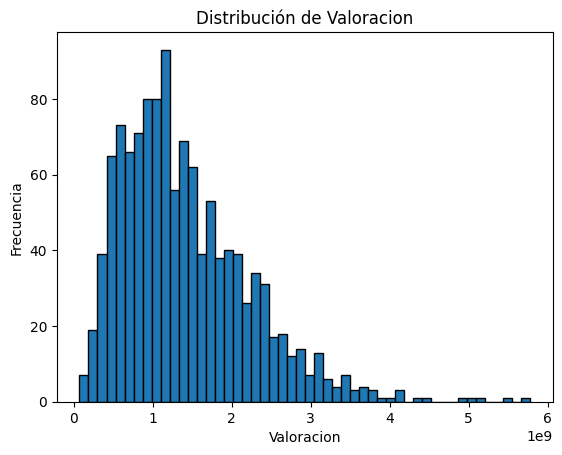

In [94]:
plt.hist(data['Valoracion'], bins=50, edgecolor='black')  # 'bins' ajusta el número de intervalos
plt.title('Distribución de Valoracion')
plt.xlabel('Valoracion')
plt.ylabel('Frecuencia')
plt.show()


In [97]:
#Ajustar la distribución gamma a los datos
shape, loc, scale = stats.gamma.fit(data['Valoracion'])

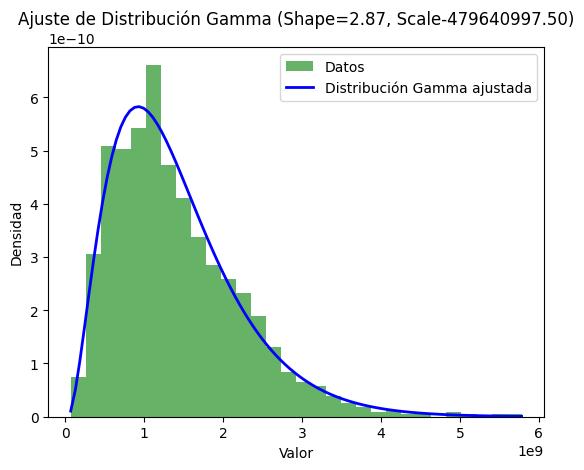

In [99]:
# Crear un rango de valores para La gráfica 
x = np.linspace(min (data['Valoracion']), max(data['Valoracion']), 100)

#Obtener La función de densidad ajustada usando Los parámetros obtenidos 
pdf_gamma_ajustada =stats.gamma.pdf(x, shape, loc, scale)

#Graficar el histograma de Los datos 
plt.hist(data['Valoracion'], bins= 30, density=True, alpha=0.6, color='g', label='Datos')

#Graficar la distribución gamma ajustada

plt.plot(x, pdf_gamma_ajustada, 'b-', linewidth=2, label='Distribución Gamma ajustada')

#Mostrar La gráfica
plt.title(f"Ajuste de Distribución Gamma (Shape={shape:.2f}, Scale-{scale:.2f})")
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.legend()
plt.show()